In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

![](realized_labeled_schem_small.png)

In [121]:
Resistors = dict(
    R=1800,
    R1=220,R2=220,R3=2200,R4=22000,
    R5=22000,R6=3300,R7=100,R8=1000,
    R9=1000,R10=1800
)

Capacitors = dict(
    C=1.e-7,C1=1e-8,C2=1e-7
)

Esat = 9

class ChuasCircuit():
    
    def __init__(self,Resistors,Capacitors,Esat):
        self.r = Resistors
        self.c = Capacitors
        self.esat = Esat
        self._init_vars()
        
    def _init_vars(self):
        
        self.G = 1./self.r['R']
        E1 = self.r['R3']/(self.r['R2']+self.r['R3'])*self.esat
        E2 = self.r['R6']/(self.r['R5']+self.r['R6'])*self.esat
        
        m12=-1./self.r['R6']
        m02=1./self.r['R4']
        m01=1./self.r['R1']
        m11=-1./self.r['R3']

        self.m1 = m12+m11
        self.m0 = m11+m02 if E1 > E2 else m12+m01
        self.mm1 = m01+m02
        
        self.emax = max([E1,E2])
        self.emin = min([E1,E2])
        
        self.L = self.r['R7']*self.r['R9']*self.c['C']*self.r['R10']/self.r['R8']
        
    def _g(self,x):
        if abs(x) < self.emin:
            self.g = x*self.m1
        elif abs(x) < self.emax:
            self.g = x*self.m0
            if x > 0:
                self.g += self.emin*(self.m1-self.m0)
            else:
                self.g += self.emin*(self.m0-self.m1)
        else:
            self.g = x*self.mm1
            if x > 0:
                self.g += self.emax*(self.m0-self.mm1) + self.emin*(self.m1-self.m0)
            else:
                self.g += self.emax*(self.mm1-self.m0) + self.emin*(self.m0-self.m1)
                
def run_chua(v,t,cc,h1,h2):
    def dxdt(x,y):
        return (1./cc.c['C1'])*(cc.G*(y-x)-cc.g)
    def dydt(x,y,z):
        return (1./cc.c['C2'])*(cc.G*(x-y)+z)
    def dzdt(y):
        return -(1./cc.L)*y

    x,y,z = v
    cc._g(x)
    return [dxdt(x,y),dydt(x,y,z),dzdt(y)]
        

In [122]:
# Initialise Variables:
x0,y0,z0 = -.5,-0.2,0.

In [129]:
cc = ChuasCircuit(Resistors,Capacitors,Esat)
C1,C2,L,G,emin,emax,m0,m1,mm1 = cc.c['C1'],cc.c['C2'],cc.L,cc.G,cc.emin,cc.emax,cc.m0,cc.m1,cc.mm1

v0 = [x0,y0,z0]
t = np.linspace(0,0.01,10000)
sol = odeint(run_chua,v0,t,args=(cc,'',''))

C:\Users\U0018301\AppData\Local\Temp/ipykernel_26304/3024624116.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


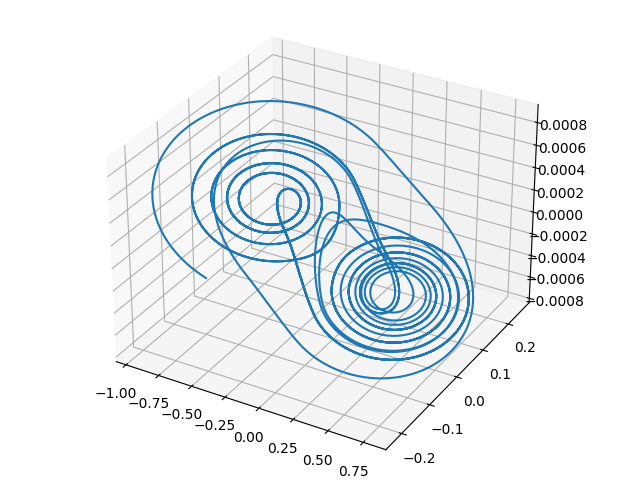

In [130]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.plot(sol.T[0],sol.T[1],sol.T[2])